# Salary and Identity Information Analysis for Atlanta City Employees (Capstone Project Submission)

* Student name: Konnor Clark
* Student pace: self paced
* Scheduled project review date/time:
* Instructor name: Morgan Jones
* Blog post URL: https://datadruid.blogspot.com/

## Project Goal:



This project uses identity information to analyze the salaries of Atlanta City employees. The goal of this created model is to help visualize and mitigate potential implicit bias in future salary tables to protect both employers and employees.

## Overview and Business Understanding/Questions



My stakeholder is the city of Atlanta, who wishes verify whether there is any bias in their current salary tables and wants to mitigate that potential implicit bias in future salary tables for their employees.  

Is there any implicit bias among the salaries of Atlanta City Employees?  

How can we mitigate any potential for implicit bias in our employees' salaries in the future?

## Data Source and Exploration



This data comes from Data World at the following site: https://data.world/brentbrewington/atlanta-city-employee-salaries. This dataset is from 2015.

Employee salary information along with identity information was gathered.

Most features in the dataset were used. These were:

 - age

 - sex

 - ethnic.origin
 
 - job.title
 
 - organization
 
 - annual.salary

The target feature is annual_salary.

## Importing, Previewing, and Cleaning the Data




In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
#Read the data and set variable
df = pd.read_csv('salaries.csv')

#Previw data
df.head()

,name,age,sex,ethnic.origin,job.title,organization,annual.salary
0,"Aaron, Dayan M",38,Male,Black or African American (Not Hispanic or Lat...,ATL311 Team Lead,EXE Executive Offices,45999.99
1,"Aaron, Freddie L",52,Male,Black or African American (Not Hispanic or Lat...,Environmental Service Worker I (D),DPW Department of Public Works,26700.10
2,"Aaron, Tyrone M",44,Male,Black or African American (Not Hispanic or Lat...,Watershed Crew Supervisor (D),DWM Department of Watershed Management,46575.01
3,"Abazenab, Kokeb",42,Female,Black or African American (Not Hispanic or Lat...,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,"Abbott, Christopher D",32,Male,White (Not Hispanic or Latino),Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


While names could play a role in implicit bias, for the purposes of this project I'm simply going to remove this column for now. 

In [3]:
#Drop name column
df = df.drop(columns='name')

In [4]:
#Preview data
df.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
0,38,Male,Black or African American (Not Hispanic or Lat...,ATL311 Team Lead,EXE Executive Offices,45999.99
1,52,Male,Black or African American (Not Hispanic or Lat...,Environmental Service Worker I (D),DPW Department of Public Works,26700.10
2,44,Male,Black or African American (Not Hispanic or Lat...,Watershed Crew Supervisor (D),DWM Department of Watershed Management,46575.01
3,42,Female,Black or African American (Not Hispanic or Lat...,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,32,Male,White (Not Hispanic or Latino),Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


In [5]:
#Check data for type and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            8246 non-null   int64  
 1   sex            8246 non-null   object 
 2   ethnic.origin  8246 non-null   object 
 3   job.title      8246 non-null   object 
 4   organization   8246 non-null   object 
 5   annual.salary  8246 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 386.7+ KB


Great, it looks like there are no null values and each type are what we would expect.

I'm curious as to the value_counts, so let's take a look.  Since age and annual.salary are numeric features, I'll drop them for this data exploration.

In [6]:
df2 = df.drop(columns=['age', 'annual.salary'])

#Extract value_counts for each feature
for column in df2:
    value_counts = df2[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print()

Value counts for column 'sex':
Male      5461
Female    2785
Name: sex, dtype: int64

Value counts for column 'ethnic.origin':
Black or African American (Not Hispanic or Latino)           6304
White (Not Hispanic or Latino)                               1642
Hispanic or Latino of any race                                170
Asian (Not Hispanic or Latino)                                103
American Indian or Alaska Native (Not Hispanic or Latino)      13
Two or More Races (Not Hispanic or Latino)                     12
Native Hawaiian or Other Pacific                                2
Name: ethnic.origin, dtype: int64

Value counts for column 'job.title':
Police Officer (E) (F) (O) (B) (S)           1226
Firefighter (E)                               473
Police Investigator (E) (F) (O)               248
Fire Sergeant (E)                             230
Police Sergeant (E) (F) (O) (B) (S)           224
                                             ... 
Police Chief, Assistant                

We only have Male and Female in the sex column, and nearly double the number of males than females. 

We have 7 categories for ethnic.origin and the vast majority is Black or African American (Not Hispanic or Latino). 

In job.title we see that the majority of positions in this dataset are for police officers, and, relatedly, in organization the majority of entires have the APD or Atlanta Police Department.

Once we get to the cleaning state, it looks like we should remove the parentheticals from ethnic.origin and job.title and perhaps rephrase the values in organization, perhaps just to the organization's abbreviations. 

First, let's take a look at this value_count data as percentages. 

In [7]:
for column in df2:
    value_counts = df2[column].value_counts()
    total_count = value_counts.sum()
    percentages = value_counts / total_count * 100

    print(f"Value counts as percentages for column '{column}':")
    print(percentages)
    print()

Value counts as percentages for column 'sex':
Male      66.226049
Female    33.773951
Name: sex, dtype: float64

Value counts as percentages for column 'ethnic.origin':
Black or African American (Not Hispanic or Latino)           76.449187
White (Not Hispanic or Latino)                               19.912685
Hispanic or Latino of any race                                2.061606
Asian (Not Hispanic or Latino)                                1.249090
American Indian or Alaska Native (Not Hispanic or Latino)     0.157652
Two or More Races (Not Hispanic or Latino)                    0.145525
Native Hawaiian or Other Pacific                              0.024254
Name: ethnic.origin, dtype: float64

Value counts as percentages for column 'job.title':
Police Officer (E) (F) (O) (B) (S)           14.867815
Firefighter (E)                               5.736114
Police Investigator (E) (F) (O)               3.007519
Fire Sergeant (E)                             2.789231
Police Sergeant (E) (F) (

We can see some of these skewed categories perhaps more easily now that we see the percentages. 

For ethnic.origin, Black or African American makes up 76.45% of the population of this data, which is in stark contrast to the demographic data of the country as a whole where Black or African Americans made up 13.8% of the population in 2015 (https://data.census.gov/table?tid=ACSDP5Y2015.DP05).  Similarly, where White people make up 19.91% of the population in this data, they made up 76.1% of the country in 2015. 

Police officers in this dataset make up 14.87% of the positions, and the police department 28.48%. 

Below I make a visuzliation for this information.  Since there are so many values for job.title, I'll remove it from the visualization for now. 

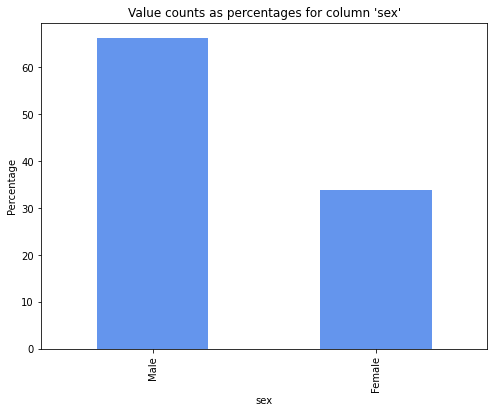

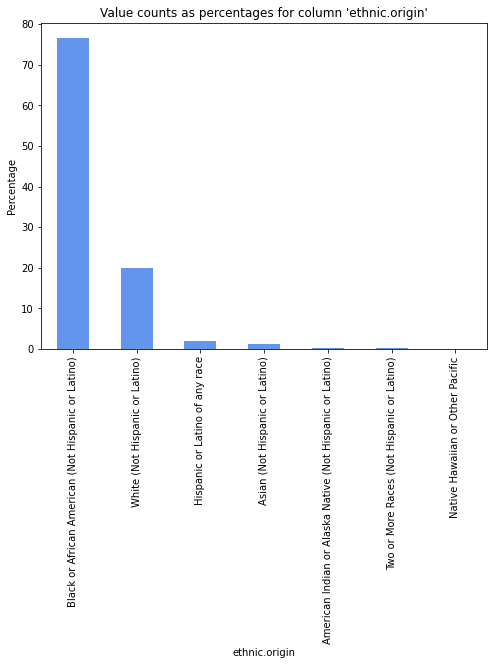

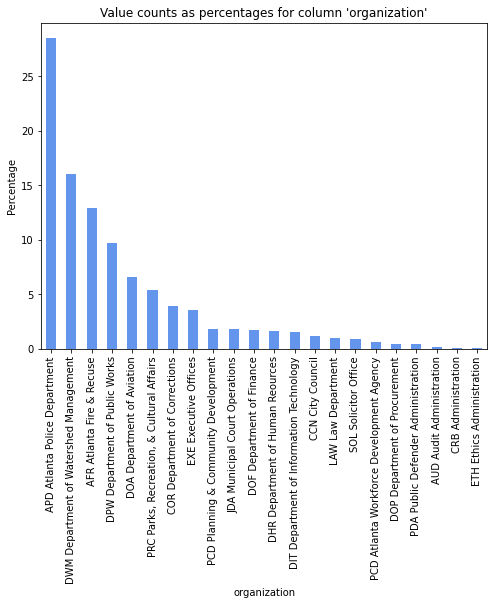

In [8]:
df3 = df2.drop(columns='job.title')

for column in df3:
    value_counts = df3[column].value_counts()
    total_count = value_counts.sum()
    percentages = value_counts / total_count * 100

    # Create a bar plot
    plt.figure(figsize=(8, 6))
    percentages.plot(kind='bar', color='cornflowerblue')
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(f"Value counts as percentages for column '{column}'")
    plt.show()

Alright, I think the distribution of the data should be clear now.  Let's do something similar for age and annual_salary.

In [9]:
# Specify the columns of interest
columns_of_interest = ['age', 'annual.salary']

# Calculate and display statistics for the specified columns
column_stats = df[columns_of_interest].describe()
print(column_stats)

               age  annual.salary
count  8246.000000    8246.000000
mean     43.186636   49040.302659
std      11.236170   20042.032049
min      19.000000   20800.000000
25%      34.000000   36916.860000
50%      44.000000   43983.430000
75%      52.000000   55279.300000
max      89.000000  240697.600000


Intersting.  So the mean age is 43 with 49040 as the mean salary. We have a large range of ages from 19-89, but most are between 34 and 52. Salaries range from 20800 to 240697, but most are between 36916 and 55279.

Let's create some visualizations of the distributions of this data.

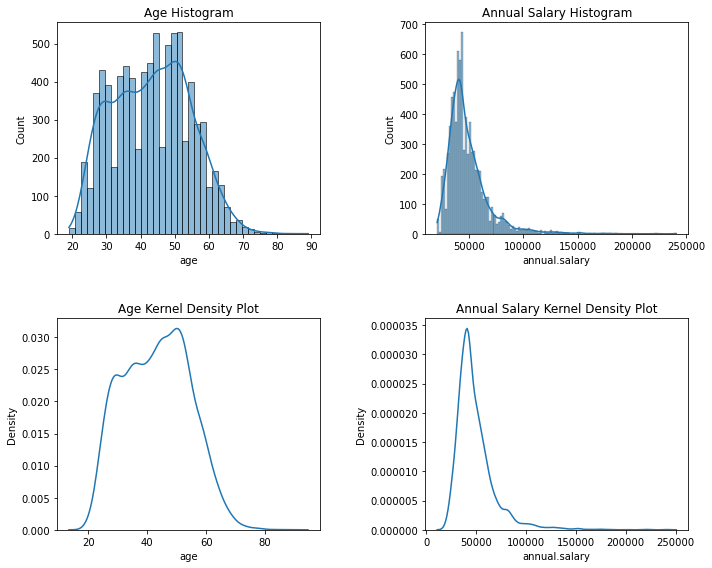

In [10]:
# Create subplots for the histograms and kernel density plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for age and annual.salary
sns.histplot(data=df, x='age', kde=True, ax=axes[0, 0])
sns.histplot(data=df, x='annual.salary', kde=True, ax=axes[0, 1])

# Plot kernel density plots for age and annual.salary
sns.kdeplot(data=df, x='age', ax=axes[1, 0])
sns.kdeplot(data=df, x='annual.salary', ax=axes[1, 1])

# Set titles for the subplots
axes[0, 0].set_title('Age Histogram')
axes[0, 1].set_title('Annual Salary Histogram')
axes[1, 0].set_title('Age Kernel Density Plot')
axes[1, 1].set_title('Annual Salary Kernel Density Plot')

# Adjust spacing between subplots
plt.tight_layout()

# Remove scientific notation from the plot
plt.ticklabel_format(style='plain', axis='both')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Show the plots
plt.show()

Let's start cleaning.  First, I noticed that the AFR Atlanta Fire & Rescue department in the organization column was mislabeled as AFR Atlanta Fire & Recuse.  Let's fix that so that our values accurately represent the department. 

In [11]:
# Define the value to be replaced and its replacement
old_value = "AFR Atlanta Fire & Recuse"
new_value = "AFR Atlanta Fire & Rescue"

# Replace the specific value in the 'organization' column
df['organization'] = df['organization'].replace(old_value, new_value)

In [12]:
df.organization.value_counts()

APD Atlanta Police Department                2349
DWM Department of Watershed Management       1325
AFR Atlanta Fire & Rescue                    1063
DPW Department of Public Works                799
DOA Department of Aviation                    544
PRC Parks, Recreation, & Cultural Affairs     447
COR Department of Corrections                 320
EXE Executive Offices                         295
PCD Planning & Community Development          153
JDA Municipal Court Operations                147
DOF Department of Finance                     145
DHR Department of Human Reources              133
DIT Department of Information Technology      124
CCN City Council                               99
LAW Law Department                             82
SOL Solicitor Office                           74
PCD Atlanta Workforce Development Agency       50
DOP Department of Procurement                  40
PDA Public Defender Administration             34
AUD Audit Administration                       13


There we go.  No more recusing with fire.  Now let's remove the parentheticals.

In [13]:
# Specify the columns to process
columns_to_process = ["ethnic.origin", "job.title"]

for column in columns_to_process:
    df[column] = df[column].apply(lambda x: re.sub(r'\(.*?\)', '', str(x)))

# Print the updated dataframe
df.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
0,38,Male,Black or African American,ATL311 Team Lead,EXE Executive Offices,45999.99
1,52,Male,Black or African American,Environmental Service Worker I,DPW Department of Public Works,26700.10
2,44,Male,Black or African American,Watershed Crew Supervisor,DWM Department of Watershed Management,46575.01
3,42,Female,Black or African American,"Benefits Representative, Sr",DHR Department of Human Reources,42866.89
4,32,Male,White,Recreation Operations Assistant,"PRC Parks, Recreation, & Cultural Affairs",28035.05


In [14]:
#Verify data count remains the same
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8246 entries, 0 to 8245
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            8246 non-null   int64  
 1   sex            8246 non-null   object 
 2   ethnic.origin  8246 non-null   object 
 3   job.title      8246 non-null   object 
 4   organization   8246 non-null   object 
 5   annual.salary  8246 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 386.7+ KB


In [15]:
#Verify removal of parentheses
df['ethnic.origin'].unique()

array(['Black or African American ', 'White ',
       'Hispanic or Latino of any race', 'Asian ',
       'American Indian or Alaska Native ', 'Two or More Races ',
       'Native Hawaiian or Other Pacific'], dtype=object)

In [16]:
#Verify removal of parentheses
df['job.title'].unique()

array(['ATL311 Team Lead', 'Environmental Service Worker I ',
       'Watershed Crew Supervisor ', 'Benefits Representative, Sr',
       'Recreation Operations Assistant', 'Management Analyst, Sr',
       'Police Investigator   ', 'Police Officer     ',
       'Management Consulting Director', 'Intern',
       'Police Lieutenant     ', 'Parks Worker II ',
       'Program Management Officer', 'Project Manager, Sr',
       'Safety & Training Officer',
       'Wastewater Collection System Operator ', 'Firefighter ',
       'Crime Scene Technician II ',
       'Airport Operations Representative III ',
       'Code Enforcement Supervisor', 'Plant Maintenance Mechanic, Sr ',
       'Fire Sergeant ', 'Electrician Specialist',
       'Facilities Maintenance Mechanic ', 'Urban Planner I',
       'Corrections Officer ', 'Pension Administrator',
       'Performance & Operations Consultant', 'Network Engineer',
       'Plant Maintenance Supervisor ', 'Gardener',
       'Police Sergeant     ', 'Cor

Great, so the parentheses have been removed!  It looks like we may have some whitespace, though, so let's remove that. 

In [17]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [18]:
#Confirm whitespace removal
df['ethnic.origin'].unique()

array(['Black or African American', 'White',
       'Hispanic or Latino of any race', 'Asian',
       'American Indian or Alaska Native', 'Two or More Races',
       'Native Hawaiian or Other Pacific'], dtype=object)

In [19]:
#Confirm whitespace removal
df['job.title'].unique()

array(['ATL311 Team Lead', 'Environmental Service Worker I',
       'Watershed Crew Supervisor', 'Benefits Representative, Sr',
       'Recreation Operations Assistant', 'Management Analyst, Sr',
       'Police Investigator', 'Police Officer',
       'Management Consulting Director', 'Intern', 'Police Lieutenant',
       'Parks Worker II', 'Program Management Officer',
       'Project Manager, Sr', 'Safety & Training Officer',
       'Wastewater Collection System Operator', 'Firefighter',
       'Crime Scene Technician II',
       'Airport Operations Representative III',
       'Code Enforcement Supervisor', 'Plant Maintenance Mechanic, Sr',
       'Fire Sergeant', 'Electrician Specialist',
       'Facilities Maintenance Mechanic', 'Urban Planner I',
       'Corrections Officer', 'Pension Administrator',
       'Performance & Operations Consultant', 'Network Engineer',
       'Plant Maintenance Supervisor', 'Gardener', 'Police Sergeant',
       'Corrections ID Technician', 'Zoning Insp

Great, it looks like the whitespace has been removed.

Let's simplify the organization to the abbreviations. First, I will print the list of unique values in this feature so that we can have it as a reference for posterity.

In [20]:
# Get the unique values in the 'organization' column and sort them alphabetically
unique_values = sorted(df['organization'].unique())

# Convert the sorted unique values to a list with each value on its own line
unique_values_list = '\n'.join(unique_values)

# Print the list of unique values
print(unique_values_list)

AFR Atlanta Fire & Rescue
APD Atlanta Police Department
AUD Audit Administration
CCN City Council
COR Department of Corrections
CRB Administration
DHR Department of Human Reources
DIT Department of Information Technology
DOA Department of Aviation
DOF Department of Finance
DOP Department of Procurement
DPW Department of Public Works
DWM Department of Watershed Management
ETH Ethics Administration
EXE Executive Offices
JDA Municipal Court Operations
LAW Law Department
PCD Atlanta Workforce Development Agency
PCD Planning & Community Development
PDA Public Defender Administration
PRC Parks, Recreation, & Cultural Affairs
SOL Solicitor Office


Great, now we can simplify the feature to the abbreviations alone. 

In [21]:
# Iterate through the 'organization' column
for i, value in enumerate(df['organization']):
    abbreviation = value[:3]  # Get the three-letter abbreviation
    df.at[i, 'organization'] = abbreviation  # Update the value in the dataframe

df.organization.value_counts()

APD    2349
DWM    1325
AFR    1063
DPW     799
DOA     544
PRC     447
COR     320
EXE     295
PCD     203
JDA     147
DOF     145
DHR     133
DIT     124
CCN      99
LAW      82
SOL      74
DOP      40
PDA      34
AUD      13
CRB       6
ETH       4
Name: organization, dtype: int64

Done, now each organization value is an abbreviation.  Our data has been cleaned.

Next, I'm interested in seeing some basic descriptive statistics for sex and ethnicity in relation to salary. 

In [22]:
# Grouping by sex and calculating descriptive statistics for annual salary
sex_stats = df.groupby('sex')['annual.salary'].describe()

# Grouping by ethnic origin and calculating descriptive statistics for annual salary
ethnic_stats = df.groupby('ethnic.origin')['annual.salary'].describe()

# Displaying the results
print("Descriptive statistics for sex and annual salary:")
print(sex_stats)

print("\nDescriptive statistics for ethnic origin and annual salary:")
print(ethnic_stats)

Descriptive statistics for sex and annual salary:
         count          mean           std      min       25%       50%  \
sex                                                                       
Female  2785.0  49051.616811  20883.543942  20800.0  35780.61  42762.72   
Male    5461.0  49034.532670  19600.924210  20800.0  37955.36  44259.49   

             75%        max  
sex                          
Female  55523.31  240697.08  
Male    55082.56  240697.60  

Descriptive statistics for ethnic origin and annual salary:
                                   count          mean           std  \
ethnic.origin                                                          
American Indian or Alaska Native    13.0  59173.613077  29262.950036   
Asian                              103.0  65621.393786  32353.824562   
Black or African American         6304.0  47046.825286  18834.552015   
Hispanic or Latino of any race     170.0  47757.899588  17892.595157   
Native Hawaiian or Other Pacific    

Let's plot these so they're a little easier to see. I'll focus on the mean and median.

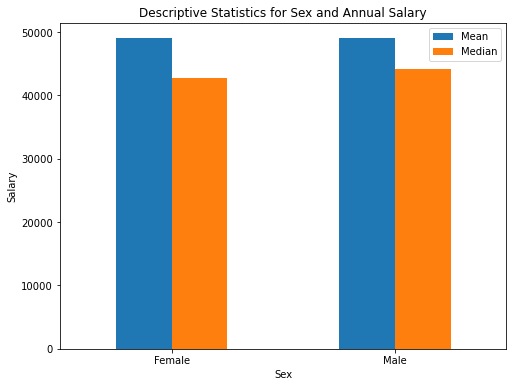

In [23]:
# Extracting necessary statistics for plotting
statistics = sex_stats[['mean', '50%']]

# Plotting the bar plot
statistics.plot(kind='bar', figsize=(8, 6))
plt.title('Descriptive Statistics for Sex and Annual Salary')
plt.xlabel('Sex')
plt.ylabel('Salary')
plt.xticks(rotation=0)
plt.legend(['Mean', 'Median'])
plt.show()

Pretty even between males and females, with the mean salaries for both groups almost identical at 49034 and 49051. The male median is slightly higher than the female median: 44259 versus 42762, a 1,587 dollar or 3.5 percent difference. Though not plotted here, the male 25th percentile is also slightly higher than the female 25th percentile: 37955 versus 35780. This would suggest that the women in this range (25th-50th percentile) make less than the men in this range.

Let's plot the ethnic.origin statistics.

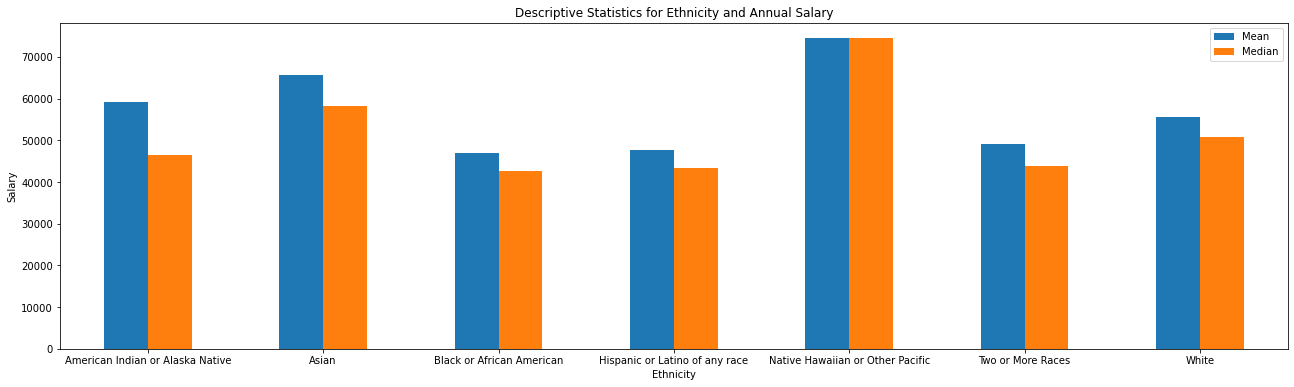

In [24]:
# Extracting necessary statistics for plotting
statistics = ethnic_stats[['mean', '50%']]

# Plotting the bar plot
statistics.plot(kind='bar', figsize=(22, 6))
plt.title('Descriptive Statistics for Ethnicity and Annual Salary')
plt.xlabel('Ethnicity')
plt.ylabel('Salary')
plt.xticks(rotation=0)
plt.legend(['Mean', 'Median'])
plt.show()

A few aspects of this data make this difficult to interpret. For one, the data has 6304 Black or African American employees and 1642 White employees. The next highest values are Hispanic or Latin at 170 employees and Asian at 103. Since we have such a skewed dataset, a bar plot like this for all the values in this column is not necessarily immediately revealing. Let's look at the two most common values side-by-side. 

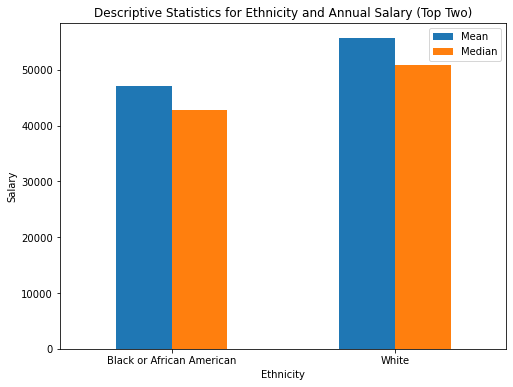

In [25]:
# Grouping by ethnic origin and calculating descriptive statistics for annual salary
ethnic_stats = df.groupby('ethnic.origin')['annual.salary'].describe()

# Sorting the ethnic_stats DataFrame based on count
sorted_stats = ethnic_stats.sort_values('count', ascending=False)

# Selecting the top two rows with highest count
top_two_stats = sorted_stats.head(2)

# Extracting necessary statistics for plotting
statistics = top_two_stats[['mean', '50%']]

# Plotting the bar plot
statistics.plot(kind='bar', figsize=(8, 6))
plt.title('Descriptive Statistics for Ethnicity and Annual Salary (Top Two)')
plt.xlabel('Ethnicity')
plt.ylabel('Salary')
plt.xticks(rotation=0)

# Modifying xtick labels
plt.xticks(range(2), ['Black or African American', 'White'])

plt.legend(['Mean', 'Median'])
plt.show()

We see that disparity between the highest values in this cateogory more apparently now.  The mean is 47046 versus 55674, and the median is 42745 and 50788.  This could prove significant enough to investigate further, but we shall see.

In [26]:
# Filter the original dataframe
df2 = df[df['ethnic.origin'].isin(['Black or African American']) | df['ethnic.origin'].isin(['White'])]

# Print the resulting dataframe
df2.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
0,38,Male,Black or African American,ATL311 Team Lead,EXE,45999.99
1,52,Male,Black or African American,Environmental Service Worker I,DPW,26700.10
2,44,Male,Black or African American,Watershed Crew Supervisor,DWM,46575.01
3,42,Female,Black or African American,"Benefits Representative, Sr",DHR,42866.89
4,32,Male,White,Recreation Operations Assistant,PRC,28035.05


In [27]:
df2['ethnic.origin'].value_counts()

Black or African American    6304
White                        1642
Name: ethnic.origin, dtype: int64

Great, so now we only have these two values in the ethnic.origin column.

Next, I'd like to look at the descriptive statistics of annual.salary in relation to job.title and ethnic.origin. 

In [28]:
df2['job.title'].value_counts()

Police Officer                  1135
Firefighter                      458
Police Investigator              238
Fire Sergeant                    224
Police Sergeant                  218
                                ... 
Business Process Analyst, Sr       1
Landfill Operator                  1
Fire Protection Engineer           1
Architectural Designer, Sr         1
Payroll Assistant                  1
Name: job.title, Length: 758, dtype: int64

There are 758 job titles, which could be cumbersome for descriptive statistics at this stage.  Let's just take a peak at the top two, Police Officers and Firefighters to see how these positions' salaries compare in relation to ethnic.origin. 

In [29]:
df2 = df2[df2['job.title'].isin(['Police Officer']) | df2['job.title'].isin(['Firefighter'])]

# Print the resulting dataframe
df2.head()

,age,sex,ethnic.origin,job.title,organization,annual.salary
7,28,Female,Black or African American,Police Officer,APD,39327.60
13,34,Male,Black or African American,Police Officer,APD,44259.49
17,39,Male,White,Police Officer,APD,58281.18
19,34,Male,Black or African American,Firefighter,AFR,37955.36
24,32,Male,Black or African American,Firefighter,AFR,37579.44


In [30]:
# Group by 'ethnic.origin' and 'job.title' and calculate descriptive statistics of 'annual.salary'
grouped_stats = df2.groupby(['job.title', 'ethnic.origin'])['annual.salary'].describe()

# Print the grouped descriptive statistics
print(grouped_stats)

                                          count          mean          std  \
job.title      ethnic.origin                                                 
Firefighter    Black or African American  299.0  36921.622910  4391.785664   
               White                      159.0  37644.057610  4031.051623   
Police Officer Black or African American  777.0  42644.480669  5493.317637   
               White                      358.0  43498.307095  5875.717373   

                                               min       25%       50%  \
job.title      ethnic.origin                                             
Firefighter    Black or African American  32132.80  35255.25  35785.83   
               White                      32132.80  35785.83  36854.61   
Police Officer Black or African American  34726.37  39919.57  42128.72   
               White                      34726.37  39919.57  42762.72   

                                               75%       max  
job.title      ethnic.o

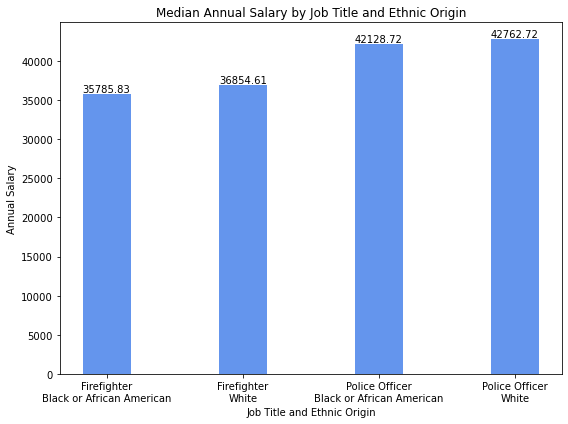

In [43]:
# Extract the mean and median values from the descriptive statistics
median_values = grouped_stats['50%']

# Define the positions for the bars
bar_width = 0.35
index = np.arange(len(grouped_stats))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the median values shifted by the bar width
bars = ax.bar(index, median_values, bar_width, color='cornflowerblue', label='Median')

# Set the x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(['\n'.join(label) for label in grouped_stats.index], rotation=0, ha='center')

# Set the axis labels and title
ax.set_xlabel('Job Title and Ethnic Origin')
ax.set_ylabel('Annual Salary')
ax.set_title('Median Annual Salary by Job Title and Ethnic Origin')

# Add a legend
ax.legend().remove()

# Add the median salary values as annotations on top of each bar
for bar, median in zip(bars, median_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{median:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

We see how the white firefighters and police officers make slightly more than their black counterparts. 

Median for black firefighter: 35785, median for white firefighter: 36854 (1069 dollars or a 3 percent difference)

Median for black police officer 42128, median for white police officer 42762 (634 dollars or 1.5 percent difference)

To showcase this potential implicit bias affecting the salaries of these positions, we also want to take a look at intersectional identities, so let's add in sex to this graph.

In [32]:
# Group by 'ethnic.origin' and 'job.title' and calculate descriptive statistics of 'annual.salary'
grouped_stats2 = df2.groupby(['job.title', 'ethnic.origin', 'sex'])['annual.salary'].describe()

# Print the grouped descriptive statistics
print(grouped_stats2)

                                                 count          mean  \
job.title      ethnic.origin             sex                           
Firefighter    Black or African American Female   19.0  35665.554211   
                                         Male    280.0  37006.856143   
               White                     Female    3.0  38271.006667   
                                         Male    156.0  37632.000897   
Police Officer Black or African American Female  180.0  42243.386444   
                                         Male    597.0  42765.413601   
               White                     Female   40.0  43795.731250   
                                         Male    318.0  43460.895252   

                                                         std       min  \
job.title      ethnic.origin             sex                             
Firefighter    Black or African American Female  2791.042397  32132.80   
                                         Male    4470.344

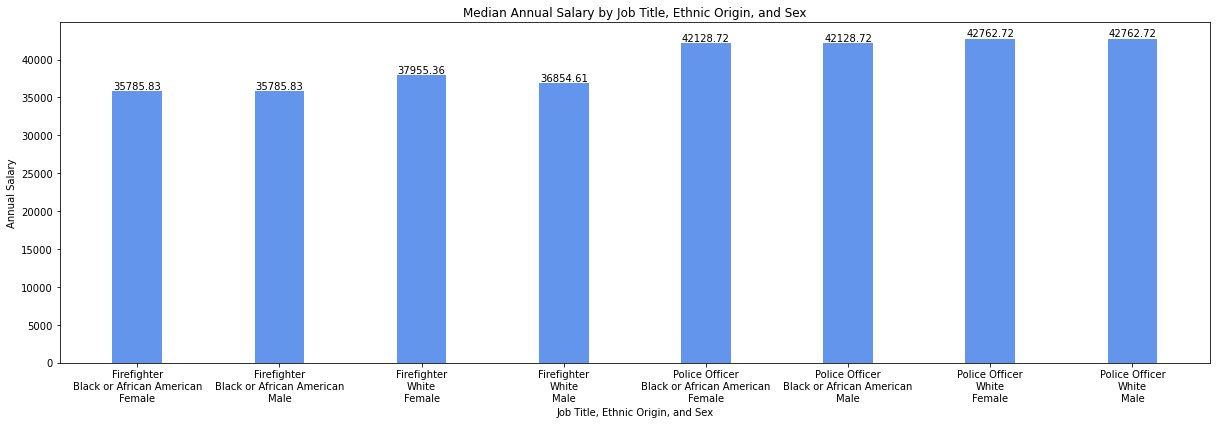

In [33]:
# Extract the median values from the descriptive statistics
median_values = grouped_stats2['50%']

# Define the positions for the bars
bar_width = 0.35
index = np.arange(len(grouped_stats2))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(17, 6))

# Plot the median values shifted by the bar width
bars = ax.bar(index, median_values, bar_width, color='cornflowerblue', label='Median')

# Set the x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(['\n'.join(label) for label in grouped_stats2.index], rotation=0, ha='center')

# Set the axis labels and title
ax.set_xlabel('Job Title, Ethnic Origin, and Sex')
ax.set_ylabel('Annual Salary')
ax.set_title('Median Annual Salary by Job Title, Ethnic Origin, and Sex')

# Add a legend
ax.legend().remove()

# Add the median salary values as annotations on top of each bar
for bar, median in zip(bars, median_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{median:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


Here, we actually see the numbers more or less even across genders within job.title, but we still see the inequity in regards to ethnic.origin.  The one exception would seem to be White, Female, Firefighters, whose median salary is higher than their male counterparts. However, there are only 3 White, Female, Firefighters compared to the 156 white male firefighters, so these low counts have potentially resulted in this outlying statistic.  Overall, we see that the median firefighter salary is less than the median police officer salary, and that the salaries of black employees are less than the salaries of white employees. 

Let's perform another exploratory analysis of the data so we can decide how linear or non-linear the relationship between the features and the target variable is.  This will help determine what kind of modeling may be best for this analysis. I will need to encode the non-numeric columns for this analysis. 

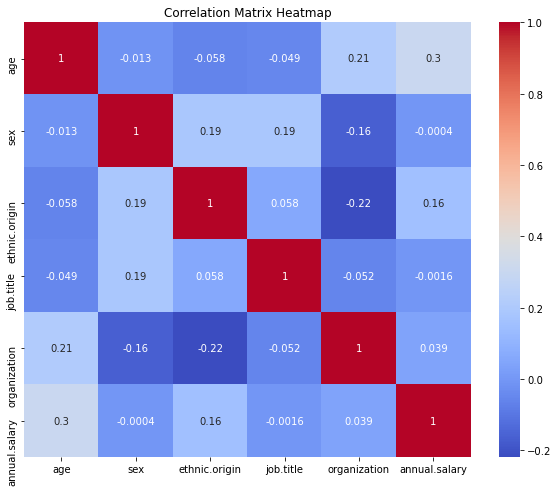

In [34]:
# Encode non-numeric columns using label encoding
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

If we simply look at the far right column, we see the highest (or lowest) values are found in age and ethnic.origin, which would suggest that these two features have the most linear relationship with annual.salary.  They are still relatively low, however, so it may be beneficial to also run a non-linear model to see our results.  Let's create some scatterplots to see this heatmap in a different way

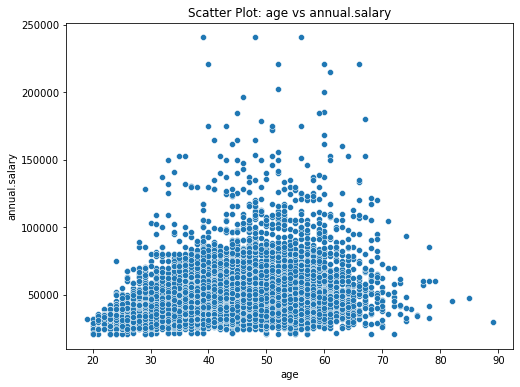

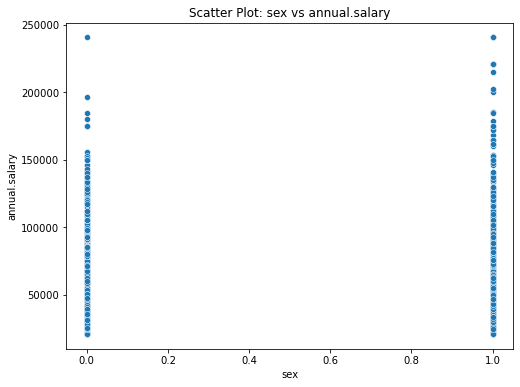

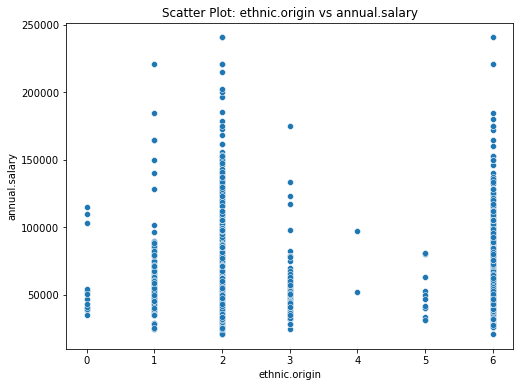

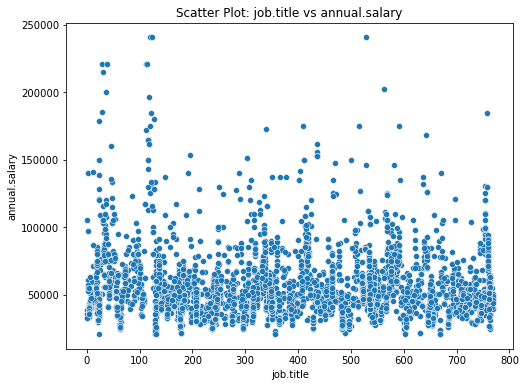

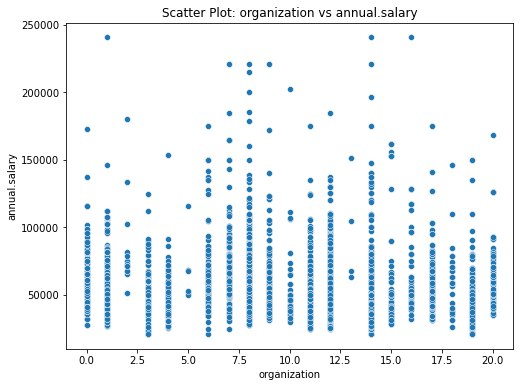

In [35]:
# Select the target variable
target_variable = 'annual.salary'

# Get the list of columns excluding the target variable
feature_columns = df.columns.drop(target_variable)

# Create scatter plots for each feature column
for column in feature_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=column, y=target_variable)
    plt.title(f'Scatter Plot: {column} vs {target_variable}')
    plt.show()

We do see that linear relationship in age, though its not as apparent in ethnic.origin with this scatterplot.  Since these are so low, and since age is likely related to experience, let's go ahead and use a non-linear approach for the modeling. 

## Manipulating the Data

In [36]:
# Select the features and target variable
features = ['age', 'sex', 'ethnic.origin', 'job.title', 'organization']
target = 'annual.salary'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Create the Decision Tree Regression model
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate the cross-validation scores
cv_scores = cross_val_score(model, df[features], df[target], cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, df[features], df[target], cv=5, scoring='r2')

# Convert the negative MSE scores to positive
cv_scores = -cv_scores

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Print the CV scores
print("Cross-Validation MSE Scores:", cv_scores)
print("Cross-Validation R^2 Scores:", cv_r2_scores)

Mean Squared Error: 217072031.09571528
R^2 Score: 0.4390995651515812
Cross-Validation MSE Scores: [2.58324456e+08 2.27622535e+08 2.37742128e+08 2.20026985e+08
 2.69815285e+08]
Cross-Validation R^2 Scores: [0.40381117 0.43008927 0.33610656 0.39830192 0.40071512]


In this initial model, the MSE is 217,072,031.09, indicating the average squared difference between the predicted and actual values. A higher MSE like this indicates poor model performance, meaning that the model's predictions are farther from the actual values.

The R^2 score of 0.439 suggests that approximately 43.9% of the variance in the target variable is explained by the model.Therefore, the model is capturing some patterns in the data, but there is still room for improvement.

The cross-validation MSE and R^2 scores provide an estimate of the model's performance on unseen data, giving an indication of how well it generalizes. It does not do so all that well currently, so let's see how we can improve it. 

In [37]:
# Create the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

# Calculate the cross-validation scores
cv_scores = cross_val_score(gb_model, df[features], df[target], cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(gb_model, df[features], df[target], cv=5, scoring='r2')

# Convert the negative MSE scores to positive
cv_scores = -cv_scores

# Print the evaluation metrics
print("Gradient Boosting - Mean Squared Error:", gb_mse)
print("Gradient Boosting - R^2 Score:", gb_r2)

# Print the CV scores
print("Cross-Validation MSE Scores:", cv_scores)
print("Cross-Validation R^2 Scores:", cv_r2_scores)

Gradient Boosting - Mean Squared Error: 193559660.07544667
Gradient Boosting - R^2 Score: 0.4998540486426898
Cross-Validation MSE Scores: [2.16088363e+08 1.80761293e+08 1.90421905e+08 1.68551527e+08
 2.27063536e+08]
Cross-Validation R^2 Scores: [0.50128815 0.54741827 0.46824799 0.53906958 0.49567074]


After using the Gradient Boosting Regression model, the MSE decreases to 193,559,660.08, indicating an improvement in the model's predictive accuracy compared to the initial scores. The R^2 score also increases to 0.499, meaning that approximately 49.9% of the variance in the target variable is explained by the Gradient Boosting model.

The cross-validation MSE and R^2 scores for the Gradient Boosting model show a similar trend. The MSE values range from approximately 1.7e+08 to 2.3e+08, with lower values indicating better performance. The R^2 scores range from 0.468 to 0.547, suggesting a better fit compared to the initial model.

In [38]:
# Define the hyperparameters to tune and their ranges
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'max_features': [None, 'sqrt', 'log2']
}

# Create the Gradient Boosting Regression model
gb_model = GradientBoostingRegressor(random_state=42)

# Define the evaluation metric
scorer = make_scorer(r2_score)

# Create the GridSearchCV object with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring=scorer, cv=5)

# Fit the grid search to the training data with cross-validation
cv_results = grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", cv_results.best_params_)
print("Best Score: ", cv_results.best_score_)

# Use the best model for predictions
best_model = cv_results.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("Best Model R^2 Score:", r2)

Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'n_estimators': 300}
Best Score:  0.683731810898395
Best Model R^2 Score: 0.7144621266578347


After performing hyperparameter tuning using GridSearchCV, the best hyperparameters for the Gradient Boosting model are listed. The best score achieved with these hyperparameters is 0.683, which is an improvement compared to the previous scores. This indicates that the model with the best hyperparameters is better at capturing the relationships in the data.

The best model's R^2 score is 0.714, suggesting that approximately 71.4% of the variance in the target variable is explained by this model. This indicates a substantial improvement compared to the initial model's R^2 score of 0.439. Overall, the best model demonstrates better predictive performance and improved ability to explain the variance in the target variable.

This model uses the potential implicit bias present in the 2015 salary table.  Therefore, it should not be used to create future equitable salaries, which will serve as a future project. This current model can be used an showcase how, in the current system, a black officer and a white officer would receive inequitable salaries.  Therefore, this model is a useful tool to showcase the inequity that could exist among 2015 Atlanta city employees' salaries.   

## Conclusion and Recommendations

My exploratory analysis of the dataset suggests that there could be implicit bias in the salaries of Atlanta City Employees. Particularly when it comes to ethnic.origin with police officers and firefighters, black employees make less than white employees.  Further exploration among different job.titles in different departments could illustrate this potential for implicit bias further. 

The final model serves as a useful tool for showcasing the potential for implicit bias given the salary and identity information from the 2015 dataset.  It should not be used to create equitable salaries for future employees (a future model), but instead be used to inform the city of Atlanta the ways in which the current system in place privileges certain employees over others. 

Additional data about the Atlanta city employees could prove useful for a full equity analysis, including years of experience, education, and additional training.  A future model could be created to combat the implicit biases and create a more equitable salary table, but this should be combined with efforts to combat the implicit biases already present in the system.  The City of Atlanta may need to investigate its hiring and advancement practices, for example, to counter the problem more effectively. 

In summary: 

Implicit bias does seem to have affected the employees of the City of Atlanta as of the 2015 data. This model provides a way to showcase that implicit bias for informative purposes and should not be implemented for the creation of an equitable salary.  